# BERT Model

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 29 18:08:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data

In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/news_classifier/'
file_list = os.listdir(folder_path)

In [ ]:
file_name = 'data_texts_pt.csv'
full_path = os.path.join(folder_path, file_name)
data_texts = pd.read_csv(full_path,index_col=False)

In [ ]:
file_name = 'data_labels_pt.csv'
full_path = os.path.join(folder_path, file_name)
data_labels = pd.read_csv(full_path, index_col=False)

## Preparing the Data

In [ ]:
data_texts = data_texts['0'].str.lower()

In [ ]:
data_labels = data_labels['categoria'].str.lower()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_labels_encoded = label_encoder.fit_transform(data_labels)

In [ ]:
# split the data into training (train_ds) and testing (test_ds) for the bert model
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels_encoded, test_size=0.2, random_state=42)

## BERT Model Training

In [ ]:
!pip install tensorflow-text==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-hub==0.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.16.1
    Uninstalling tensorflow-hub-0.16.1:
      Successfully uninstalled tensorflow-hub-0.16.1


In [ ]:
import tensorflow_hub as hub

In [ ]:
import tensorflow_text as text

In [ ]:
print(hub.__version__)

0.15.0


In [ ]:
print(text.__version__)

2.15.0


In [ ]:
def build_model(model_preprocess, model_encoder):
    # Create an input layer that accepts text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')

    # Preprocess the text using the provided preprocessing model
    preprocessor = hub.KerasLayer(model_preprocess, name='preprocessor')
    encoder_inputs = preprocessor(text_input)

    # Encode the preprocessed text using the provided BERT encoder model
    encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Retrieve the pooled output from the BERT encoder which represents the entire input sequence
    net = outputs["pooled_output"]

    # Apply dropout for regularization
    net = tf.keras.layers.Dropout(0.1)(net)

    # Add a dense layer with softmax activation to classify into 29 categories
    net = tf.keras.layers.Dense(29, activation='softmax', name='classifier')(net)

    # Construct the final model with text input and output layers
    model = tf.keras.models.Model(text_input, net)

    return model

In [ ]:
# Define the URL for the BERT preprocessing model on TensorFlow Hub
tfhub_handle_preprocess = 'https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/multi-cased-preprocess/3'

# Define the URL for the BERT encoder model on TensorFlow Hub
tfhub_handle_encoder = 'https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/multi-cased-l-12-h-768-a-12/4'

In [ ]:
# Instantiate a new model using the BERT preprocessing and encoder URLs
test_model = build_model(tfhub_handle_preprocess, tfhub_handle_encoder)

In [ ]:
# Define the loss function for the model as Sparse Categorical Crossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
# Create an Adam optimizer with the specified learning rate
init_lr = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

In [ ]:
# Compile the model with the specified optimizer, loss function, and evaluation metric
test_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=['acc'])

In [ ]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 preprocessor (KerasLayer)   {'input_mask': (None, 128)   0         ['text_input[0][0]']          
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
test_history = test_model.fit(train_texts, train_labels,validation_data=(val_texts, val_labels), epochs=10, batch_size=64)

Epoch 1/10
378/378 [==============================] - 723s 2s/step - loss: 1.9785 - acc: 0.4439 - val_loss: 1.4392 - val_acc: 0.5829
Epoch 2/10
378/378 [==============================] - 690s 2s/step - loss: 1.2481 - acc: 0.6307 - val_loss: 1.2563 - val_acc: 0.6256
Epoch 3/10
378/378 [==============================] - 690s 2s/step - loss: 0.9708 - acc: 0.7064 - val_loss: 1.2344 - val_acc: 0.6416
Epoch 4/10
378/378 [==============================] - 689s 2s/step - loss: 0.7513 - acc: 0.7741 - val_loss: 1.2790 - val_acc: 0.6332
Epoch 5/10
378/378 [==============================] - 689s 2s/step - loss: 0.5694 - acc: 0.8278 - val_loss: 1.3812 - val_acc: 0.6367
Epoch 6/10
378/378 [==============================] - 689s 2s/step - loss: 0.4187 - acc: 0.8719 - val_loss: 1.4344 - val_acc: 0.6436
Epoch 7/10
378/378 [==============================] - 689s 2s/step - loss: 0.3056 - acc: 0.9067 - val_loss: 1.5320 - val_acc: 0.6415
Epoch 8/10
378/378 [==============================] - 689s 2s/step - 

In [ ]:
model_path = '/content/drive/My Drive/news_classifier/bert_model_pt.keras'
test_model.save(model_path)

In [ ]:
def plot_graphs(history, string):
	plt.plot(history.history[string])
	plt.plot(history.history['val_'+string])
	plt.xlabel("Epochs")
	plt.ylabel(string)
	plt.legend([string, 'val_'+string])
	plt.show()

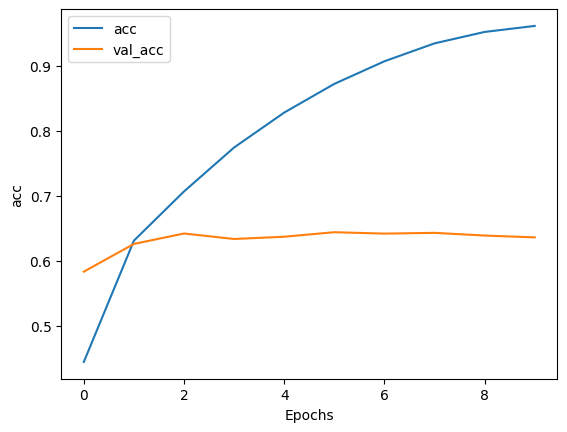

In [ ]:
plot_graphs(test_history, 'acc')

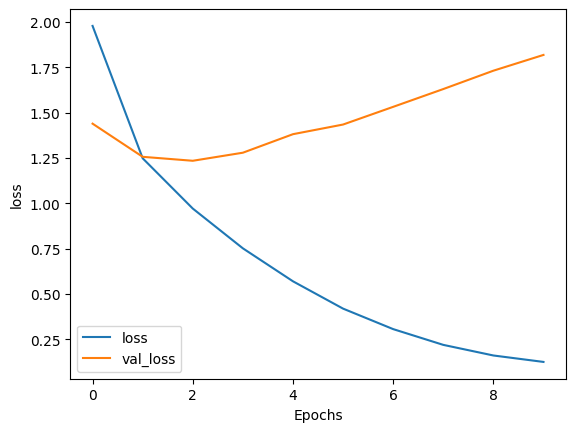

In [ ]:
plot_graphs(test_history, 'loss')

In [ ]:
file_name = 'bert_model_pt'
full_path = os.path.join(folder_path, file_name)

In [ ]:
test_model.save(full_path)